In [1]:
# Import Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statistics
import fastcluster
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from itertools import permutations
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D

In [2]:
wine = pd.read_csv('wine.csv')
wine_noindex = pd.read_csv('wine.csv', index_col=False)  
#print(f'\t*Wine-Original : \n\n{wine.head()}')
wine_columns = wine.columns

categorical_features = ['Wine']
numerical_features = ['Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue','OD', 'Proline']
cat_data = wine_noindex[categorical_features]

scaler = MinMaxScaler(feature_range=(-1, 1))
x = pd.DataFrame(scaler.fit_transform(wine_noindex[numerical_features]))
x.columns = numerical_features
x_comb = pd.concat([cat_data, x], axis=1)
print(f'\n----> SCALED DATASET : \n\n{x_comb}')
s_row, s_col = x.shape

s_row, s_col = x.shape
print(f'\n*\tSamples : {s_row}, Dimensions : {len(wine.columns)}')

#sns.pairplot(data=x_comb, hue='Wine', height=2)
#plt.plot()


----> SCALED DATASET : 

     Wine   Alcohol  Malic.acid       Ash       Acl        Mg   Phenols  \
0       1  0.684211   -0.616601  0.144385 -0.484536  0.239130  0.255172   
1       1  0.142105   -0.588933 -0.165775 -0.938144 -0.347826  0.151724   
2       1  0.121053   -0.359684  0.401070 -0.175258 -0.326087  0.255172   
3       1  0.757895   -0.521739  0.219251 -0.360825 -0.065217  0.979310   
4       1  0.163158   -0.268775  0.614973  0.072165  0.043478  0.255172   
..    ...       ...         ...       ...       ...       ...       ...   
173     3  0.410526    0.940711  0.165775  0.020619 -0.456522 -0.517241   
174     3  0.247368    0.252964  0.197861  0.278351 -0.304348 -0.434483   
175     3  0.178947    0.399209 -0.037433 -0.030928  0.086957 -0.579310   
176     3  0.126316   -0.268775  0.080214 -0.030928  0.086957 -0.537931   
177     3  0.631579    0.328063  0.475936  0.432990 -0.434783 -0.262069   

     Flavanoids  Nonflavanoid.phenols   Proanth  Color.int       Hue  \
0

In [3]:
## ----------- MEDIAN ABSOLUTE DEVIATION (MAD) correlation matrix ---------------

def compute_median_absolute_deviation(df):
    return df.apply(lambda col: np.absolute(col - col.median()))

def generate_corr_elems(columns):
    comb = permutations(columns, 2)
    perms = list(comb)
    diag = [(col, col) for col in columns]
    return diag + perms

def compute_corr_matrix_values(df, corr_elems):
    corr_values = []
    for elem in corr_elems:
        corr_values.append(df[elem[0]].append(df[elem[1]], ignore_index=True).median(axis=0))
    return corr_values

def construct_corr_matrix(corr_values, num_columns):
    matrix = np.diag(corr_values[:num_columns])
    k = 0
    for i in range(num_columns):
        for j in range(num_columns):
            if i != j:
                matrix[i, j] = corr_values[num_columns:][k]
                k += 1
    return matrix

# Compute the Median Absolute Deviation
x_MAD = compute_median_absolute_deviation(x)
print(f'\n ---> Median Absolute Deviation : \n\n{x_MAD}')

# Generate the correlation matrix elements
corr_elems = generate_corr_elems(x_MAD.columns)
print(f'\n ---> The elements of the corr matrix are : \n\n{corr_elems}')

# Compute the correlation matrix values
corr_values = compute_corr_matrix_values(x_MAD, corr_elems)
print(f'\n ---> The values of the corr_elems are : \n')
for i, value in zip(corr_elems, corr_values):
    print(f'*The median of the columns ({i[0]},{i[1]}) -> {value}')

# Construct the correlation matrix
corr_matrix = construct_corr_matrix(corr_values, x_MAD.shape[1])
print(f'\n ---> Correlation matrix : \n\n{corr_matrix}')


 ---> Median Absolute Deviation : 

      Alcohol  Malic.acid       Ash       Acl        Mg   Phenols  Flavanoids  \
0    0.621053    0.061265  0.074866  0.402062  0.630435  0.306897    0.390295   
1    0.078947    0.033597  0.235294  0.855670  0.043478  0.203448    0.263713   
2    0.057895    0.195652  0.331551  0.092784  0.065217  0.306897    0.466245   
3    0.694737    0.033597  0.149733  0.278351  0.326087  1.031034    0.571730   
4    0.100000    0.286561  0.545455  0.154639  0.434783  0.306897    0.234177   
..        ...         ...       ...       ...       ...       ...         ...   
173  0.347368    1.496047  0.096257  0.103093  0.065217  0.465517    0.643460   
174  0.184211    0.808300  0.128342  0.360825  0.086957  0.382759    0.584388   
175  0.115789    0.954545  0.106952  0.051546  0.478261  0.527586    0.609705   
176  0.063158    0.286561  0.010695  0.051546  0.478261  0.486207    0.613924   
177  0.568421    0.883399  0.406417  0.515464  0.043478  0.210345    0.5

In [4]:
# Eigen Value & Eigen Vector Decomposition

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Print the sorted eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

eig_vals_total = sum(eigenvalues)
explained_variance = [(i / eig_vals_total)*100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)
print('\nExplained variance             : {}'.format(explained_variance))

print('Cumulative explained variance  : {}'.format(cum_explained_variance))

Eigenvalues:
[ 3.62391679e+00  3.75492416e-02  2.27977206e-02  1.93213020e-02
  1.22397636e-02  8.01692270e-03  6.16206549e-03 -1.47483181e-03
 -8.96116102e-03 -1.28327271e-02 -1.47363683e-02 -3.25521996e-02
 -3.92675097e-02]

Eigenvectors:
[[-0.31442    -0.11282986 -0.02328875 -0.26727448 -0.07208586 -0.35403201
  -0.58465024 -0.1751306  -0.0422208  -0.12608933  0.51026939 -0.10892716
   0.15326028]
 [-0.24311531 -0.05811875  0.38662052  0.17120871 -0.29391144 -0.28973608
  -0.22520618  0.06560774 -0.1460395   0.25134612 -0.28102182  0.53123032
  -0.29613316]
 [-0.22478658  0.20424667  0.1437678  -0.11521712  0.11467598  0.35320536
  -0.04733174 -0.02866372  0.48341378 -0.43399693  0.17696381  0.27002319
  -0.45450268]
 [-0.2459078   0.12125175 -0.07842604 -0.16520352  0.45581172  0.14759557
   0.18098616 -0.43338423 -0.34996137  0.10985092  0.03548912  0.48858617
   0.25834427]
 [-0.23342378  0.75005991  0.10480858  0.25216128  0.17518144 -0.3428411
   0.13404908  0.04774263 -0.13360


New projection:
     Wine         0         1         2         3         4         5
0       1 -0.317955 -0.384722 -0.259243  0.622578  0.407761 -0.267049
1       1  0.598800 -0.795962  0.104281  0.416164  0.302982 -0.165538
2       1 -0.204116 -0.378624 -0.516592  0.302800  0.238257  0.168377
3       1 -0.637533 -0.503470 -0.252193  0.556977  0.336578  0.233177
4       1 -0.012623  0.027022  0.234310  0.092811  0.243064 -0.050680
..    ...       ...       ...       ...       ...       ...       ...
173     3  0.632046  0.290868  0.866819 -0.316649 -0.755200  0.167580
174     3  0.776788  0.471356  0.326173 -0.380420 -0.352024  0.273835
175     3  0.744447  0.764918  0.408781 -0.186461 -0.583051  0.360647
176     3  0.775347  0.882406  0.228545 -0.316008 -0.471100  0.575314
177     3  0.394449  0.497463  0.616475 -0.605483 -0.741265  0.538117

[178 rows x 7 columns]


[]

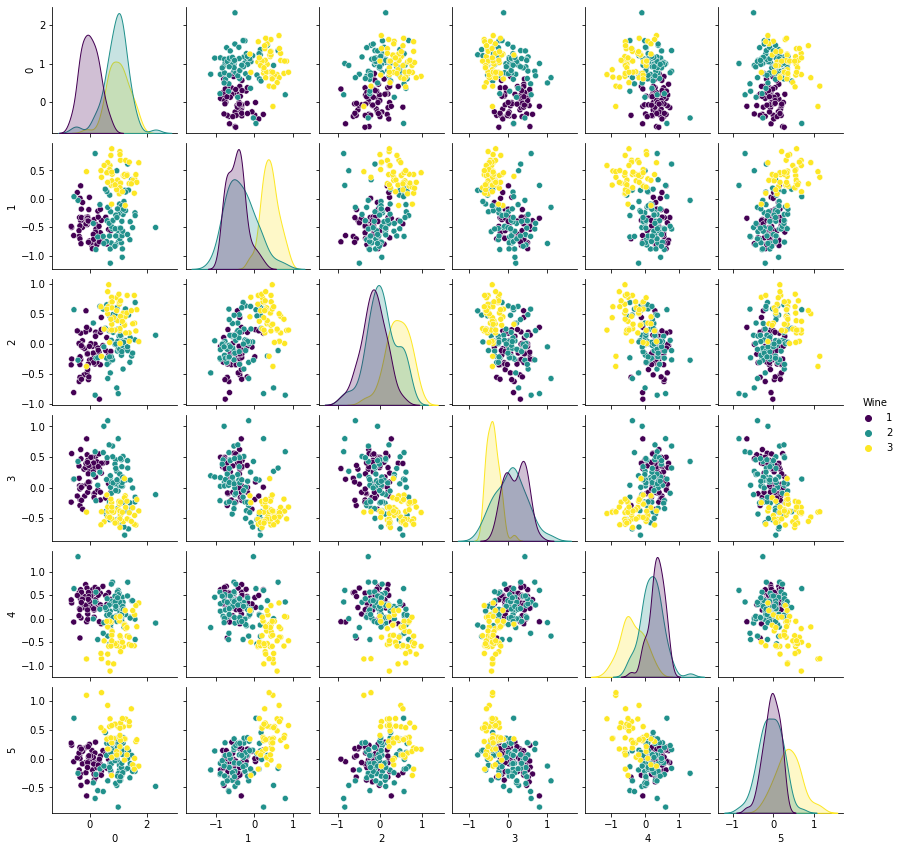

In [5]:
# Data Transformation.

# Select 'k' no of eigen vectors
k = 6
W = eigenvectors[:, :k] # Projection matrix

# Transform the original dataset
X_proj = x.dot(W)
X_proj_fin = pd.concat([cat_data, X_proj], axis=1)
X_proj_fin.to_csv('columns_heatmap.csv', index=False)
print('\nNew projection:')
print(X_proj_fin)
#print(X_proj)

sns.pairplot(data=X_proj_fin, hue='Wine', height=2, palette="viridis")
plt.plot()

In [6]:

# Calculate the end points of the PC axes (scaled by the square root of the absolute eigenvalues)
#pc_endpoints = eigenvectors * np.sqrt(np.abs(eigenvalues))
  
#def Original():
    
    # Set the figure size
    #plt.figure(figsize=(8, 8))

    #df = pd.DataFrame(X_proj_fin)

    # Plot the DataFrame using Seaborn's scatterplot function
    #sns.scatterplot(x=X_proj_fin[0], y=X_proj_fin[1],hue = X_proj_fin['Wine'],style=X_proj_fin['Wine'],palette="Set1", data=df)

    # Show the plot
    #plt.xlabel('Feature 1')
    #plt.ylabel('Feature 2')
    #plt.title('Transformed Data')
    #plt.grid(True)
    #plt.axis('equal')
    #plt.show()
    

#Original()
#Transformed()


In [7]:
X_proj_1D = X_proj.to_numpy()
#X_proj_1D = X_proj.flatten()[::-1]

# Calculate the condensed distance matrix
condensed_dist_matrix = pdist(X_proj_1D)

# Convert the condensed distance matrix to a square distance matrix
dist_matrix = pd.DataFrame(squareform(condensed_dist_matrix))

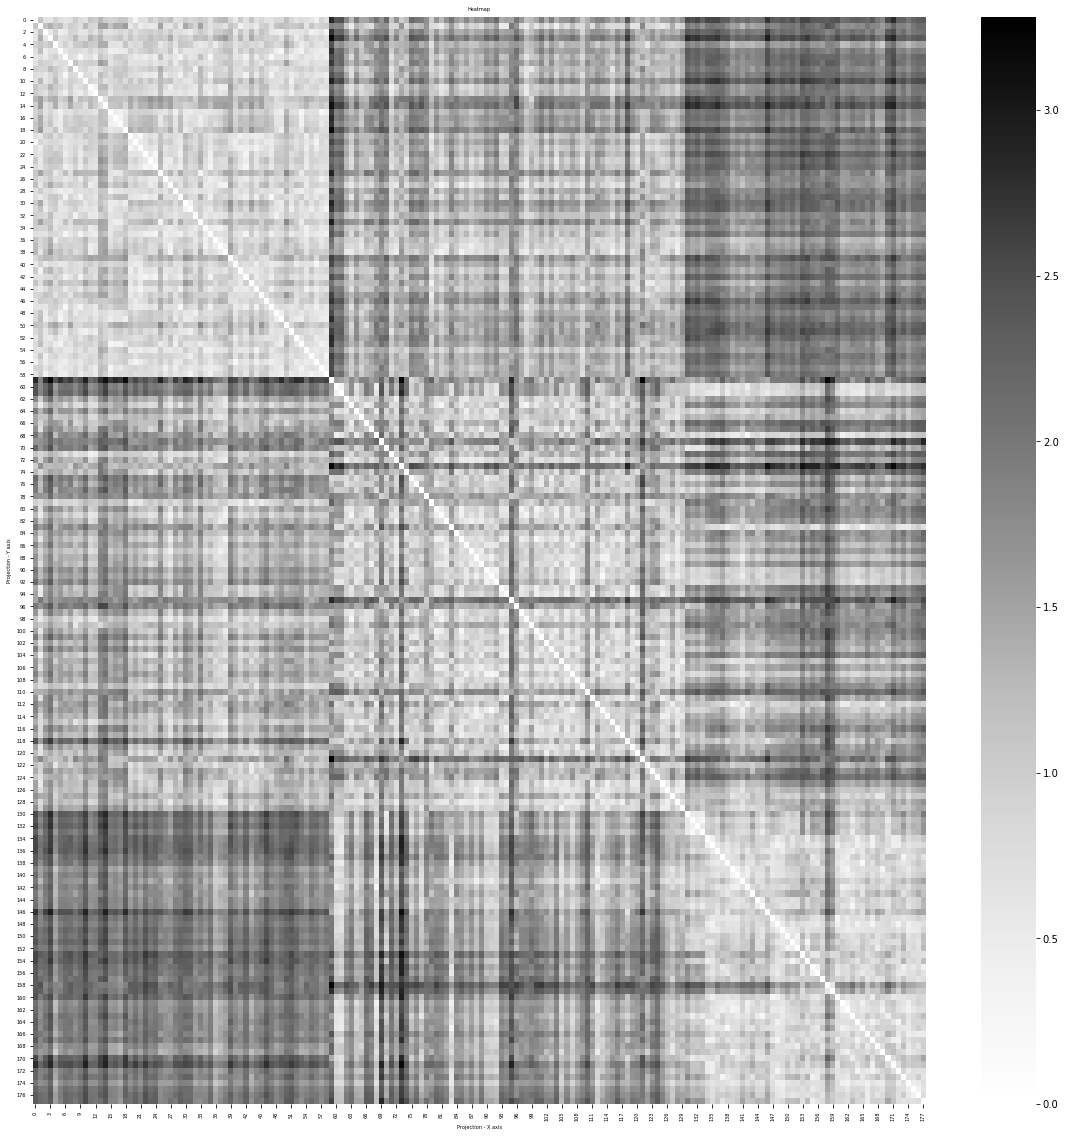

In [8]:
plt.figure(figsize=(20, 20))
sns.heatmap(dist_matrix, cmap='Greys', annot=False, annot_kws={"size": 10})

title_fontsize = 5
label_fontsize = 5

plt.title('Heatmap', fontsize=title_fontsize)
plt.xlabel('Projection - X axis', fontsize=label_fontsize)
plt.ylabel('Projection - Y axis', fontsize=label_fontsize)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

plt.show()

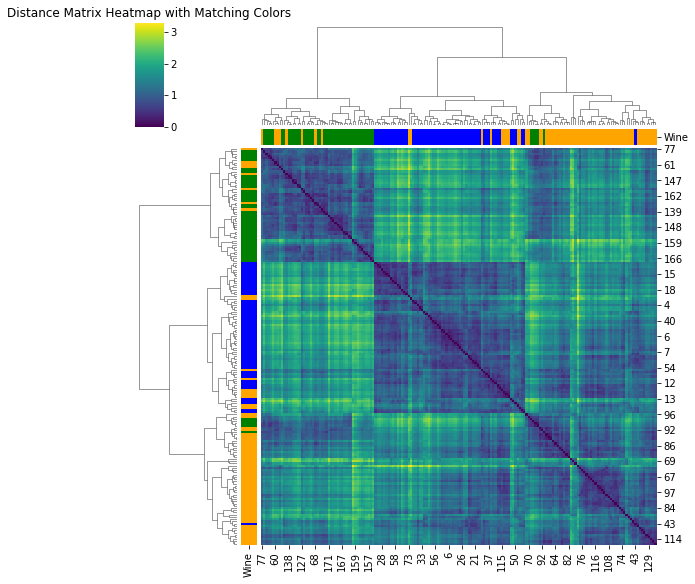

In [9]:
# Create a color mapping based on the species
species_color_mapping = X_proj_fin['Wine'].map({1: 'blue', 2: 'orange', 3: 'green'})

# Create a clustermap using the distance matrix and fastcluster with matching colors
linkage_matrix = fastcluster.linkage(condensed_dist_matrix, method='ward')
sns.clustermap(dist_matrix, cmap='viridis', figsize=(8, 8), row_linkage=linkage_matrix, col_linkage=linkage_matrix,
               row_colors=species_color_mapping, col_colors=species_color_mapping)

# Show the plot
plt.title('Distance Matrix Heatmap with Matching Colors')
plt.show()

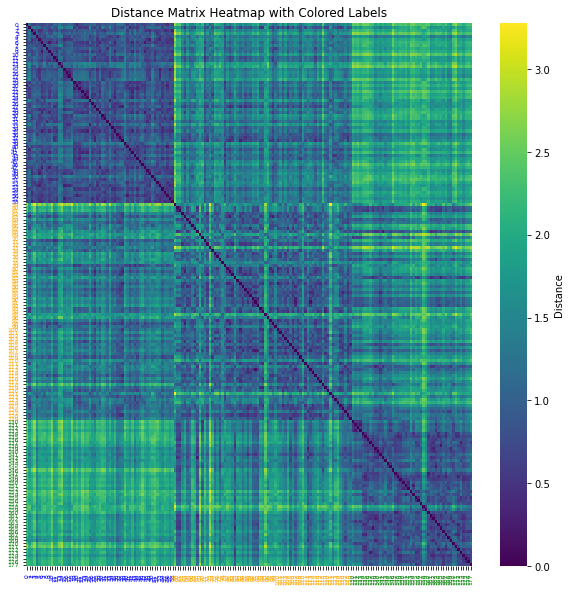

In [10]:
# Create a custom color mapping based on the species
species_color_mapping = X_proj_fin['Wine'].map({1: 'blue', 2: 'orange', 3: 'green'})

# Plot the distance matrix heatmap with colored labels
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_matrix, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Distance'})

# Set the tick labels and colors
ax.set_xticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_yticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_xticklabels(species_color_mapping.index, rotation=90, fontsize=6)
ax.set_yticklabels(species_color_mapping.index, rotation=0, fontsize=6)

# Color the tick labels
for tick, color in zip(ax.get_xticklabels(), species_color_mapping):
    tick.set_color(color)

for tick, color in zip(ax.get_yticklabels(), species_color_mapping):
    tick.set_color(color)

# Show the plot
plt.title('Distance Matrix Heatmap with Colored Labels')
plt.show()

In [11]:
# Dump to CSV

dist_matrix.to_csv('COMAD_3_dim.csv', index=False)